In [1]:
import pandas as pd

# data preparation
df = pd.read_csv('bank_marketing.csv')
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [2]:
numerical_column = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical_column = ['lead_source', 'industry', 'employment_status', 'location']

# cek missing value
print(df[numerical_column].isnull().sum())
print(df[categorical_column].isnull().sum())

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64
lead_source          128
industry             134
employment_status    100
location              63
dtype: int64


In [3]:
# create fill dictionary based on column types
fill_dict = {}

# for numerical columns  
for col in numerical_column:
    fill_dict[col] = 0.0

# for categorical columns
for col in categorical_column:
    fill_dict[col] = 'NA'

# fill all at once
df = df.fillna(fill_dict)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [4]:
# split data for validation framework
from sklearn.model_selection import train_test_split

# need to split data to 60 train 20 val and 20 test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [5]:
# 1.
from sklearn.metrics import roc_auc_score

def evaluate_specific_features_auc(X_train, y_train, features_list):
    """
    Evaluate specific numerical features using ROC AUC as standalone predictors
    """
    results = []
    
    for feature in features_list:
        # Check if feature exists in the dataframe
        if feature not in X_train.columns:
            print(f"Warning: Feature '{feature}' not found in training data")
            continue
            
        # Use the feature itself as the prediction score
        scores = X_train[feature].values
        
        # Calculate AUC
        try:
            auc = roc_auc_score(y_train, scores)
            
            # Check if we need to invert the feature
            needs_inversion = auc < 0.5
            final_auc = 1 - auc if needs_inversion else auc
            
            results.append({
                'feature': feature,
                'auc': final_auc,
                'original_auc': auc,
                'needs_inversion': needs_inversion,
                'direction': 'negative' if needs_inversion else 'positive'
            })
            
        except Exception as e:
            print(f"Error calculating AUC for {feature}: {e}")
    
    # Create results dataframe and sort by AUC
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('auc', ascending=False)
        return results_df
    else:
        return pd.DataFrame()

# run the evaluation on the 4 specific features
feature_auc_results = evaluate_specific_features_auc(df_train, y_train, numerical_column)
feature_auc_results

,feature,auc,original_auc,needs_inversion,direction
0,number_of_courses_viewed,0.763568,0.763568,False,positive
2,interaction_count,0.738270,0.738270,False,positive
3,lead_score,0.614499,0.614499,False,positive
1,annual_income,0.551958,0.551958,False,positive


In [6]:
# 2
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Select only categorical columns for DictVectorizer
X_train_categorical = df_train[categorical_column]
X_val_categorical = df_val[categorical_column]

# Convert categorical columns to dictionaries
train_dict = X_train_categorical.to_dict(orient='records')
val_dict = X_val_categorical.to_dict(orient='records')

# Apply one-hot encoding to categorical features only
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dict)
X_val_encoded = dv.transform(val_dict)

X_train_numerical = df_train[numerical_column].values
X_val_numerical = df_val[numerical_column].values

# Combine encoded categorical features with numerical features
X_train_combined = np.hstack([X_train_numerical, X_train_encoded])
X_val_combined = np.hstack([X_val_numerical, X_val_encoded])

print("Feature dimensions:")
print(f"Original training shape: {df_train.shape}")
print(f"Categorical encoded: {X_train_encoded.shape}")
print(f"Numerical features: {X_train_numerical.shape}")
print(f"Combined features: {X_train_combined.shape}")

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_combined, y_train)

# Make predictions on validation set
y_val_pred = model.predict_proba(X_val_combined)[:, 1]

# Calculate AUC on validation set
auc_score = roc_auc_score(y_val, y_val_pred)
auc_rounded = round(auc_score, 3)

print(f"\n🎯 VALIDATION AUC RAW: {auc_score}")
print(f"\n🎯 VALIDATION AUC: {auc_rounded}")

Feature dimensions:
Original training shape: (876, 8)
Categorical encoded: (876, 27)
Numerical features: (876, 4)
Combined features: (876, 31)

🎯 VALIDATION AUC RAW: 0.8171316268814112

🎯 VALIDATION AUC: 0.817


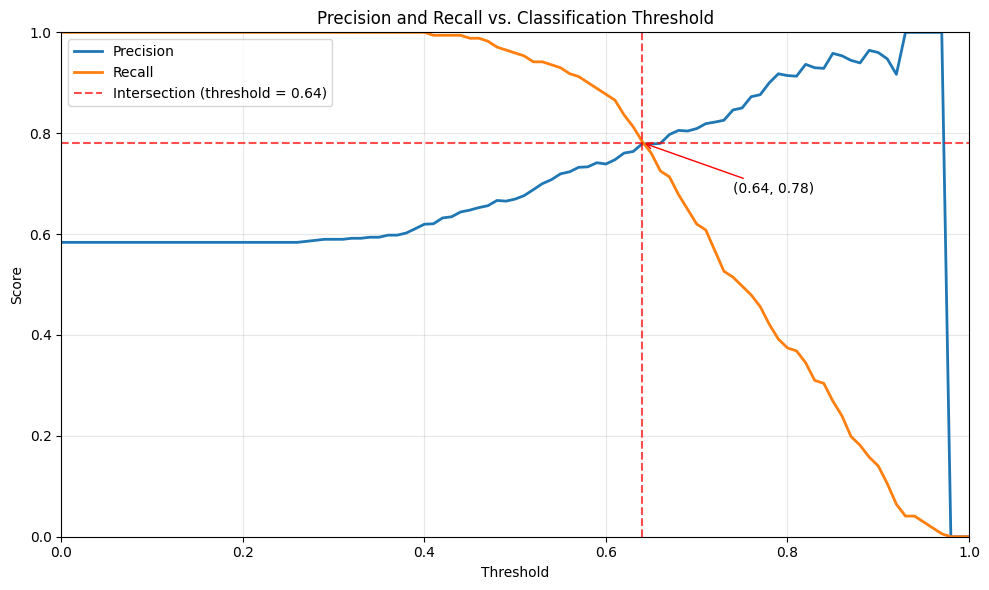


📊 Precision-Recall Analysis:
Intersection threshold: 0.64
Precision at intersection: 0.779
Recall at intersection: 0.784


In [7]:
# 3.
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store precision and recall values
precisions = []
recalls = []

# Get predicted probabilities from our model
y_val_pred_proba = model.predict_proba(X_val_combined)[:, 1]

# Compute precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions using threshold
    y_val_pred_binary = (y_val_pred_proba >= threshold).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_val_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_val_pred_binary, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Find the intersection point (where precision == recall)
intersection_threshold = None
intersection_value = None

for i, (p, r) in enumerate(zip(precisions, recalls)):
    # Find where precision and recall are closest
    if abs(p - r) < 0.01:  # Using a small tolerance
        intersection_threshold = thresholds[i]
        intersection_value = (p + r) / 2  # Average of precision and recall at intersection
        break

# If no exact intersection found, find the closest one
if intersection_threshold is None:
    differences = [abs(p - r) for p, r in zip(precisions, recalls)]
    closest_idx = np.argmin(differences)
    intersection_threshold = thresholds[closest_idx]
    intersection_value = (precisions[closest_idx] + recalls[closest_idx]) / 2

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

# Mark the intersection point
plt.axvline(x=intersection_threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Intersection (threshold = {intersection_threshold:.2f})')
plt.axhline(y=intersection_value, color='red', linestyle='--', alpha=0.7)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Classification Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Annotate the intersection point
plt.annotate(f'({intersection_threshold:.2f}, {intersection_value:.2f})', 
             xy=(intersection_threshold, intersection_value), 
             xytext=(intersection_threshold + 0.1, intersection_value - 0.1),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

print(f"\n📊 Precision-Recall Analysis:")
print(f"Intersection threshold: {intersection_threshold:.2f}")
print(f"Precision at intersection: {precision_score(y_val, (y_val_pred_proba >= intersection_threshold).astype(int), zero_division=0):.3f}")
print(f"Recall at intersection: {recall_score(y_val, (y_val_pred_proba >= intersection_threshold).astype(int), zero_division=0):.3f}")

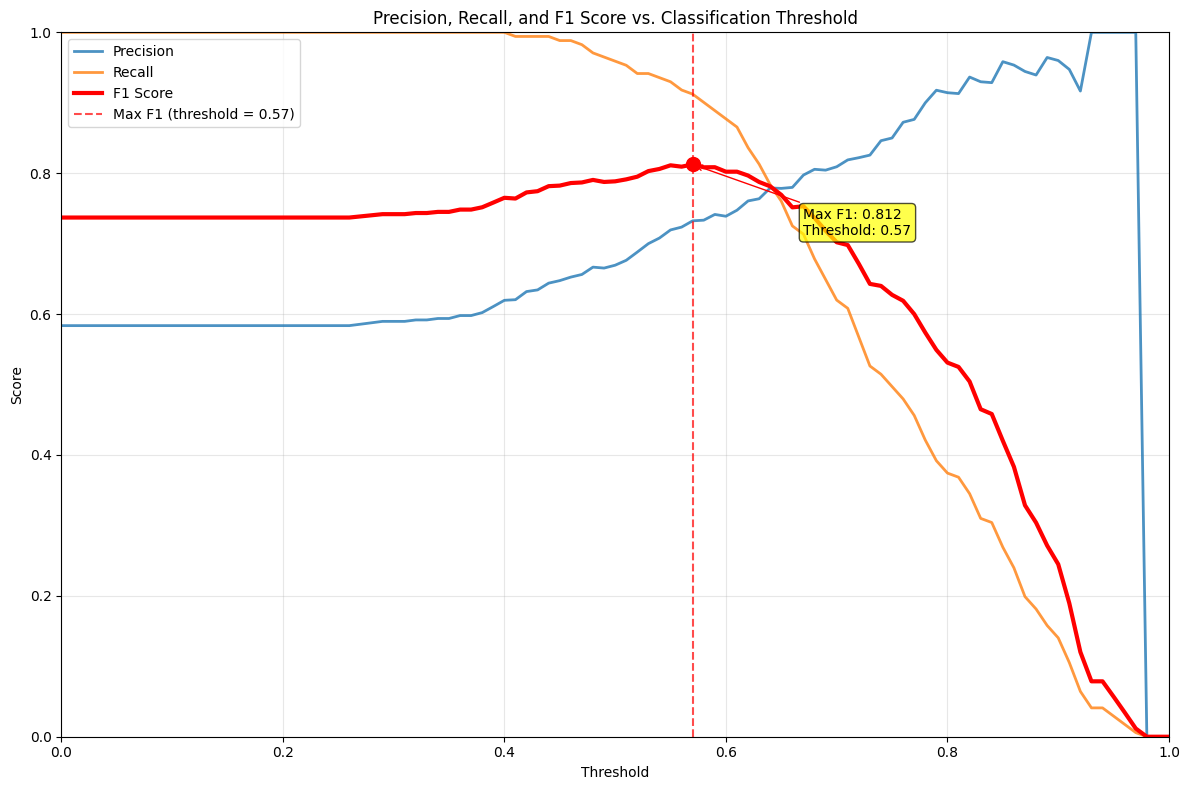


🎯 F1 SCORE ANALYSIS:
Maximum F1 score: 0.812
Optimal threshold: 0.57
Precision at optimal threshold: 0.732
Recall at optimal threshold: 0.912


In [8]:
# 4.
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store metrics
precisions = []
recalls = []
f1_scores = []

# Get predicted probabilities from our model
y_val_pred_proba = model.predict_proba(X_val_combined)[:, 1]

# Compute metrics for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions using threshold
    y_val_pred_binary = (y_val_pred_proba >= threshold).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_val_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_val_pred_binary, zero_division=0)
    
    # Compute F1 score using the formula: F1 = 2 * (precision * recall) / (precision + recall)
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

# Also get precision and recall at the optimal threshold
optimal_precision = precisions[max_f1_idx]
optimal_recall = recalls[max_f1_idx]

# Plot all three metrics
plt.figure(figsize=(12, 8))

# Plot precision, recall, and F1
plt.plot(thresholds, precisions, label='Precision', linewidth=2, alpha=0.8)
plt.plot(thresholds, recalls, label='Recall', linewidth=2, alpha=0.8)
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=3, color='red')

# Mark the maximum F1 point
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Max F1 (threshold = {max_f1_threshold:.2f})')

plt.scatter([max_f1_threshold], [max_f1_value], color='red', s=100, zorder=5)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Annotate the maximum F1 point
plt.annotate(f'Max F1: {max_f1_value:.3f}\nThreshold: {max_f1_threshold:.2f}', 
             xy=(max_f1_threshold, max_f1_value), 
             xytext=(max_f1_threshold + 0.1, max_f1_value - 0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n🎯 F1 SCORE ANALYSIS:")
print(f"Maximum F1 score: {max_f1_value:.3f}")
print(f"Optimal threshold: {max_f1_threshold:.2f}")
print(f"Precision at optimal threshold: {optimal_precision:.3f}")
print(f"Recall at optimal threshold: {optimal_recall:.3f}")

In [9]:
# 5. 
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare the full training data
df_full_train_features = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted'].values

# Define categorical columns
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = [col for col in df_full_train_features.columns if col not in categorical_columns]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC scores for each fold
auc_scores = []
fold_details = []

print("🚀 Starting 5-Fold Cross-Validation on df_full_train")
print("=" * 50)

# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train_features), 1):
    print(f"\n📊 Processing Fold {fold}/5...")
    
    # Split the data
    X_train_fold = df_full_train_features.iloc[train_idx]
    X_val_fold = df_full_train_features.iloc[val_idx]
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # Prepare categorical features
    X_train_cat = X_train_fold[categorical_columns]
    X_val_cat = X_val_fold[categorical_columns]
    
    # Apply DictVectorizer to categorical features
    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(X_train_cat.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val_cat.to_dict(orient='records'))
    
    # Get numerical features
    X_train_num = X_train_fold[numerical_columns].values
    X_val_num = X_val_fold[numerical_columns].values
    
    # Combine features
    X_train_combined = np.hstack([X_train_num, X_train_encoded])
    X_val_combined = np.hstack([X_val_num, X_val_encoded])
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_combined, y_train_fold)
    
    # Make predictions and calculate AUC
    y_val_pred = model.predict_proba(X_val_combined)[:, 1]
    auc = roc_auc_score(y_val_fold, y_val_pred)
    
    # Store results
    auc_scores.append(auc)
    fold_details.append({
        'fold': fold,
        'train_size': len(X_train_fold),
        'val_size': len(X_val_fold),
        'auc': auc
    })
    
    print(f"   Fold {fold} - Train size: {len(X_train_fold)}, Val size: {len(X_val_fold)}")
    print(f"   Fold {fold} AUC: {auc:.4f}")

# Convert to numpy array for easier calculations
auc_scores = np.array(auc_scores)

# Calculate statistics
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
min_auc = np.min(auc_scores)
max_auc = np.max(auc_scores)

print("\n" + "=" * 50)
print("📊 CROSS-VALIDATION RESULTS")
print("=" * 50)

# Print individual fold results
print("\n📈 Individual Fold Results:")
for detail in fold_details:
    print(f"   Fold {detail['fold']}: AUC = {detail['auc']:.4f}")

print(f"\n🎯 Summary Statistics:")
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Standard Deviation: {std_auc:.4f}")
print(f"Minimum AUC: {min_auc:.4f}")
print(f"Maximum AUC: {max_auc:.4f}")
print(f"Range: {max_auc - min_auc:.4f}")

# Print the final answer
print(f"\n✅ STANDARD DEVIATION OF AUC SCORES: {std_auc:.4f}")

🚀 Starting 5-Fold Cross-Validation on df_full_train

📊 Processing Fold 1/5...
   Fold 1 - Train size: 935, Val size: 234
   Fold 1 AUC: 0.8061

📊 Processing Fold 2/5...
   Fold 2 - Train size: 935, Val size: 234
   Fold 2 AUC: 0.8714

📊 Processing Fold 3/5...
   Fold 3 - Train size: 935, Val size: 234
   Fold 3 AUC: 0.7754

📊 Processing Fold 4/5...
   Fold 4 - Train size: 935, Val size: 234
   Fold 4 AUC: 0.8018

📊 Processing Fold 5/5...
   Fold 5 - Train size: 936, Val size: 233
   Fold 5 AUC: 0.8558

📊 CROSS-VALIDATION RESULTS

📈 Individual Fold Results:
   Fold 1: AUC = 0.8061
   Fold 2: AUC = 0.8714
   Fold 3: AUC = 0.7754
   Fold 4: AUC = 0.8018
   Fold 5: AUC = 0.8558

🎯 Summary Statistics:
Mean AUC: 0.8221
Standard Deviation: 0.0358
Minimum AUC: 0.7754
Maximum AUC: 0.8714
Range: 0.0959

✅ STANDARD DEVIATION OF AUC SCORES: 0.0358


In [10]:
# 6.
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare the full training data
df_full_train_features = df_full_train.drop('converted', axis=1)
y_full_train = df_full_train['converted'].values

# Define categorical columns
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = [col for col in df_full_train_features.columns if col not in categorical_columns]

# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results
results = {}

print("🚀 Starting 5-Fold Cross-Validation for C Parameter Tuning")
print("=" * 60)

# Iterate over C values
for C in C_values:
    print(f"\n🔧 Testing C = {C}")
    
    auc_scores = []
    
    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train_features), 1):
        # Split the data
        X_train_fold = df_full_train_features.iloc[train_idx]
        X_val_fold = df_full_train_features.iloc[val_idx]
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Prepare categorical features
        X_train_cat = X_train_fold[categorical_columns]
        X_val_cat = X_val_fold[categorical_columns]
        
        # Apply DictVectorizer to categorical features
        dv = DictVectorizer(sparse=False)
        X_train_encoded = dv.fit_transform(X_train_cat.to_dict(orient='records'))
        X_val_encoded = dv.transform(X_val_cat.to_dict(orient='records'))
        
        # Get numerical features
        X_train_num = X_train_fold[numerical_columns].values
        X_val_num = X_val_fold[numerical_columns].values
        
        # Combine features
        X_train_combined = np.hstack([X_train_num, X_train_encoded])
        X_val_combined = np.hstack([X_val_num, X_val_encoded])
        
        # Train the model with current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_combined, y_train_fold)
        
        # Make predictions and calculate AUC
        y_val_pred = model.predict_proba(X_val_combined)[:, 1]
        auc = roc_auc_score(y_val_fold, y_val_pred)
        auc_scores.append(auc)
        
        print(f"   Fold {fold}: AUC = {auc:.4f}")
    
    # Calculate mean and std for current C value
    auc_scores = np.array(auc_scores)
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results[C] = {
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3),
        'all_scores': auc_scores
    }
    
    print(f"   ✅ C = {C}: Mean AUC = {mean_auc:.3f} ± {std_auc:.3f}")

print("\n" + "=" * 60)
print("📊 C PARAMETER TUNING RESULTS")
print("=" * 60)

# Find the best C value
best_C = None
best_mean_auc = -1

for C, result in results.items():
    print(f"C = {C}: Mean AUC = {result['mean_auc']} ± {result['std_auc']}")
    
    if result['mean_auc'] > best_mean_auc:
        best_mean_auc = result['mean_auc']
        best_C = C

print(f"\n🎯 BEST PARAMETER: C = {best_C}")
print(f"   Best Mean AUC: {best_mean_auc}")

# Display detailed comparison
print(f"\n📈 DETAILED COMPARISON:")
for C, result in results.items():
    marker = " 🏆" if C == best_C else ""
    print(f"C = {C:10}: Mean = {result['mean_auc']:6} ± {result['std_auc']:6}{marker}")

🚀 Starting 5-Fold Cross-Validation for C Parameter Tuning

🔧 Testing C = 1e-06
   Fold 1: AUC = 0.5572
   Fold 2: AUC = 0.5192
   Fold 3: AUC = 0.5895
   Fold 4: AUC = 0.5582
   Fold 5: AUC = 0.5769
   ✅ C = 1e-06: Mean AUC = 0.560 ± 0.024

🔧 Testing C = 0.001
   Fold 1: AUC = 0.8609
   Fold 2: AUC = 0.8967
   Fold 3: AUC = 0.8228
   Fold 4: AUC = 0.8540
   Fold 5: AUC = 0.9000
   ✅ C = 0.001: Mean AUC = 0.867 ± 0.029

🔧 Testing C = 1
   Fold 1: AUC = 0.8061
   Fold 2: AUC = 0.8714
   Fold 3: AUC = 0.7754
   Fold 4: AUC = 0.8018
   Fold 5: AUC = 0.8558
   ✅ C = 1: Mean AUC = 0.822 ± 0.036

📊 C PARAMETER TUNING RESULTS
C = 1e-06: Mean AUC = 0.56 ± 0.024
C = 0.001: Mean AUC = 0.867 ± 0.029
C = 1: Mean AUC = 0.822 ± 0.036

🎯 BEST PARAMETER: C = 0.001
   Best Mean AUC: 0.867

📈 DETAILED COMPARISON:
C =      1e-06: Mean =   0.56 ±  0.024
C =      0.001: Mean =  0.867 ±  0.029 🏆
C =          1: Mean =  0.822 ±  0.036
